In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
# LBM D2Q9 lattice scheme configuration
##############
#  6   2   5
#   \  |  /
# 3 —— 0 —— 1
#   /  |  \
#  7   4   8
##############

Nq = 9  # Number of lattice directions
Nx = 32  # Number of grid points in x-direction
Ny = 32  # Number of grid points in y-direction
Nt = 100  # Number of timesteps

# Lattice vector definition
ei = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8])
ci = np.array([[0, 1, 0, -1, 0, 1, -1, -1, 1], 
               [0, 0, 1, 0, -1, 1, 1, -1, -1]])

# Lattice weights definition
omega1, omega2, omega3 = 1.0, 1.5, 1.9
weights = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])

In [3]:
# Meshgrid definition in 2D XY domain
t = np.arange(Nt)
xm = np.arange(Nx)
ym = np.arange(Ny)
X, Y = np.meshgrid(xm, ym, indexing='ij')

# fi field initialization
A_x = 0.3
k_x = 1
fi = np.zeros((Nx, Ny, Nq))

for i, wi in zip(ei, weights):
    fi[X, Y, i] = wi * (1 + A_x * np.cos(2 * np.pi * k_x * Y / Ny) * ci[0][i])
            
fi1, fi2, fi3 = fi, fi, fi

In [4]:
def streaming(fi):
    for i in ei:
        # Propagate fi value in each corresponding direction using np.roll
        fi[:, :, i] = np.roll(fi[:, :, i], ci[0][i], axis=0) # roll along x
        fi[:, :, i] = np.roll(fi[:, :, i], ci[1][i], axis=1) # roll along y

    return fi

In [5]:
def get_matrix(omega):
    # Calculate matrix A
    ci_cj = np.tensordot(ci[0], ci[0], axes=0) + np.tensordot(ci[1], ci[1], axes=0) # ci is equivalent to cj
    L_ij = np.transpose(weights * (1 + 3 * ci_cj))
    A_ij = (1 - omega) * np.eye(Nq) + omega * L_ij

    # Calculate matrix B
    Q_ijk = np.zeros((Nq, Nq, Nq))
    for i in range(Nq):
        for j in range(Nq):
            for k in range(Nq):
                ci_cj = ci[0][i] * ci[0][j] + ci[1][i] * ci[1][j]
                ci_ck = ci[0][i] * ci[0][k] + ci[1][i] * ci[1][k]
                cj_ck = ci[0][j] * ci[0][k] + ci[1][j] * ci[1][k]
                Q_ijk[i, j, k] = 9 * weights[i] * (ci_cj * ci_ck - cj_ck / 3)
    B_ijk = omega * Q_ijk
    
    return A_ij, B_ijk

In [6]:
def collision_BGK(fi_pre, A_ij, B_ijk):
    ones = np.ones(Nq)
    f_j, f_k, f_l = np.squeeze(fi_pre), np.squeeze(fi_pre), np.squeeze(fi_pre)

    A_i = np.einsum('ij,NMj->NMi', A_ij, f_j) # N stands for y direction and M for x

    B_ik = np.einsum('ijk,NMj->NMik', B_ijk, f_j)
    B_i = np.einsum('NMik,NMk->NMi', B_ik, f_k)

    # B_il calculations are less time-consuming(4 times faster than stric matrix form of C)
    B_il = np.zeros((Nx, Ny, Nq, Nq))
    for x in range(Nx):
        for y in range(Ny):
            B_il[x, y] = np.transpose(np.tensordot(ones, B_i[x, y], axes=0))
    C_i = - np.einsum('NMil,NMl->NMi', B_il, f_l) / 2

    fi_collisioned = A_i + B_i + C_i
    
    return fi_collisioned

In [7]:
def get_macro_quantities(fi):
    rho = np.sum(fi, 2)  # Density
    ux = np.sum(fi * ci[0], 2) / rho 
    uy = np.sum(fi * ci[1], 2) / rho
    
    return rho, ux, uy

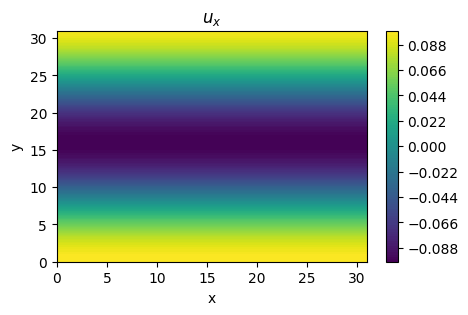

In [8]:
_, ux0, uy0 = get_macro_quantities(fi)
u0 = np.sqrt(ux0**2 + uy0**2)

plt.figure(figsize=(5, 3))
contour = plt.contourf(X, Y, ux0, levels=100, cmap='viridis', vmin=-0.1, vmax=0.1)
plt.colorbar(contour)
plt.title("$u_x$")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [9]:
fi1s, u1s = [], []
A_ij1, B_ijk1 = get_matrix(omega1)
for i in range(Nt):
    fi1s.append(fi1)
    _, ux1, uy1 = get_macro_quantities(fi1)
    ui = np.sqrt(ux1**2 + uy1**2)
    u1 = ui[16, 16] / u0[16, 16]
    u1s.append(u1)
    
    fi1 = collision_BGK(fi1, A_ij1, B_ijk1)
    fi1 = streaming(fi1)
    

fi2s, u2s = [], []
A_ij2, B_ijk2 = get_matrix(omega2)
for i in range(Nt):
    fi2s.append(fi2)
    _, ux2, uy2 = get_macro_quantities(fi2)
    ui = np.sqrt(ux2**2 + uy2**2)
    u2 = ui[16, 16] / u0[16, 16]
    u2s.append(u2)
    
    fi2 = collision_BGK(fi2, A_ij2, B_ijk2)
    fi2 = streaming(fi2)
    

fi3s, u3s = [], []
A_ij3, B_ijk3 = get_matrix(omega3)
for i in range(Nt):
    fi3s.append(fi3)
    _, ux3, uy3 = get_macro_quantities(fi3)
    ui = np.sqrt(ux3**2 + uy3**2)
    u3 = ui[16, 16] / u0[16, 16]
    u3s.append(u3)
    
    fi3 = collision_BGK(fi3, A_ij3, B_ijk3)
    fi3 = streaming(fi3)

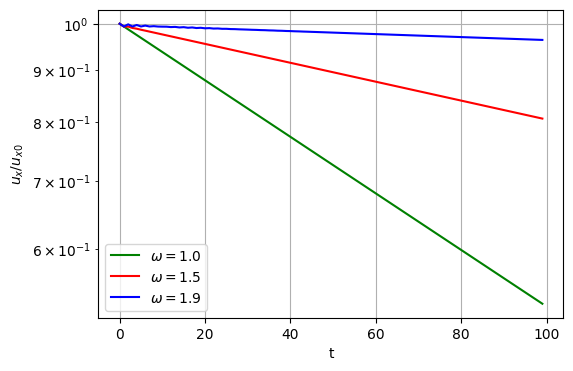

In [10]:
plt.figure(figsize=(6, 4))
plt.plot(t, u1s, label="$\\omega = 1.0$", color="green")
plt.plot(t, u2s, label="$\\omega = 1.5$", color="red")
plt.plot(t, u3s, label="$\\omega = 1.9$", color="blue")
plt.xlabel("t")
plt.yscale("log")
plt.ylabel("$u_x/u_{x0}$")
plt.grid(True)
plt.legend()
plt.savefig("ux_evolution_LBM.pdf", format='pdf')  # Vector export
plt.show()

In [11]:
fi_all = np.stack((fi1s, fi2s, fi3s), axis=0)
np.save("fi_exact_x.npy", fi_all)